In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [01:52<00:00, 40.6MB/s]
100% 3.24G/3.24G [01:52<00:00, 31.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:
# Define the directory containing the dataset
image_dir = Path('/content/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convert filepaths and labels to pandas Series
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

# Sample 800 images from each class
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(800, random_state=1))

# Combine sampled images into a single DataFrame and shuffle
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Display the DataFrame
image_df.head()

Filepath               Label
0  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...            Sea Bass
1  /content/Fish_Dataset/Fish_Dataset/Trout/Trout...               Trout
2  /content/Fish_Dataset/Fish_Dataset/Red Sea Bre...       Red Sea Bream
3  /content/Fish_Dataset/Fish_Dataset/Black Sea S...     Black Sea Sprat
4  /content/Fish_Dataset/Fish_Dataset/Striped Red...  Striped Red Mullet

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [ ]:
print("Training DataFrame:")
train_df.head()

Training DataFrame:


Filepath            Label
4607  /content/Fish_Dataset/Fish_Dataset/Gilt-Head B...  Gilt-Head Bream
1437  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...         Sea Bass
4632  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel
348   /content/Fish_Dataset/Fish_Dataset/Trout/Trout...            Trout
1566  /content/Fish_Dataset/Fish_Dataset/Red Mullet/...       Red Mullet

In [ ]:
print("\nTesting DataFrame:")
test_df.head()


Testing DataFrame:


Filepath               Label
7152  /content/Fish_Dataset/Fish_Dataset/Striped Red...  Striped Red Mullet
6074  /content/Fish_Dataset/Fish_Dataset/Black Sea S...     Black Sea Sprat
1790  /content/Fish_Dataset/Fish_Dataset/Red Sea Bre...       Red Sea Bream
3242  /content/Fish_Dataset/Fish_Dataset/Trout/Trout...               Trout
4067  /content/Fish_Dataset/Fish_Dataset/Black Sea S...     Black Sea Sprat

In [ ]:
# Define the data generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 4032 validated image filenames belonging to 9 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1008 validated image filenames belonging to 9 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2160 validated image filenames belonging to 9 classes.


Transfer Learning using Predefined Models

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classifier_activation="softmax",
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Extract features from images using the pre-trained model
def extract_features(generator):
    features = pretrained_model.predict(generator)
    labels = generator.classes
    return features, labels

# Extract features for training, validation, and test sets
train_features, train_labels = extract_features(train_images)
val_features, val_labels = extract_features(val_images)
test_features, test_labels = extract_features(test_images)

68/68 [==============================] - 21s 305ms/step


In [ ]:
inputs = pretrained_model.input

In [ ]:
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

This compiles the model, setting the optimizer to Adam, the loss function to categorical crossentropy (suitable for multiclass classification), and the metric to track during training as accuracy

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
126/126 [==============================] - 56s 407ms/step - loss: 0.2334 - accuracy: 0.9355 - val_loss: 0.0278 - val_accuracy: 0.9921
Epoch 2/5
126/126 [==============================] - 51s 404ms/step - loss: 0.0150 - accuracy: 0.9978 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 3/5
126/126 [==============================] - 51s 405ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0886 - val_accuracy: 0.9702
Epoch 4/5
126/126 [==============================] - 51s 403ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.0086 - val_accuracy: 0.9970
Epoch 5/5
126/126 [==============================] - 51s 402ms/step - loss: 9.8162e-04 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9990


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report
predictions = model.predict(test_images)
y_true = test_images.classes
y_pred = np.argmax(predictions, axis=1)
classification_rep = classification_report(y_true, y_pred)
print("Classification Report:\n", classification_rep)

conf_matrix = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(y_true, predictions, average='weighted', multi_class='ovr')

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

68/68 [==============================] - 22s 320ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       263
           1       1.00      1.00      1.00       224
           2       1.00      1.00      1.00       234
           3       1.00      1.00      1.00       230
           4       1.00      1.00      1.00       224
           5       1.00      1.00      1.00       232
           6       1.00      1.00      1.00       249
           7       1.00      1.00      1.00       252
           8       1.00      1.00      1.00       252

    accuracy                           1.00      2160
   macro avg       1.00      1.00      1.00      2160
weighted avg       1.00      1.00      1.00      2160

Confusion Matrix:
 [[263   0   0   0   0   0   0   0   0]
 [  0 224   0   0   0   0   0   0   0]
 [  0   0 234   0   0   0   0   0   0]
 [  0   0   0 230   0   0   0   0   0]
 [  0   0   0   0 224   0   0   0   0]
 

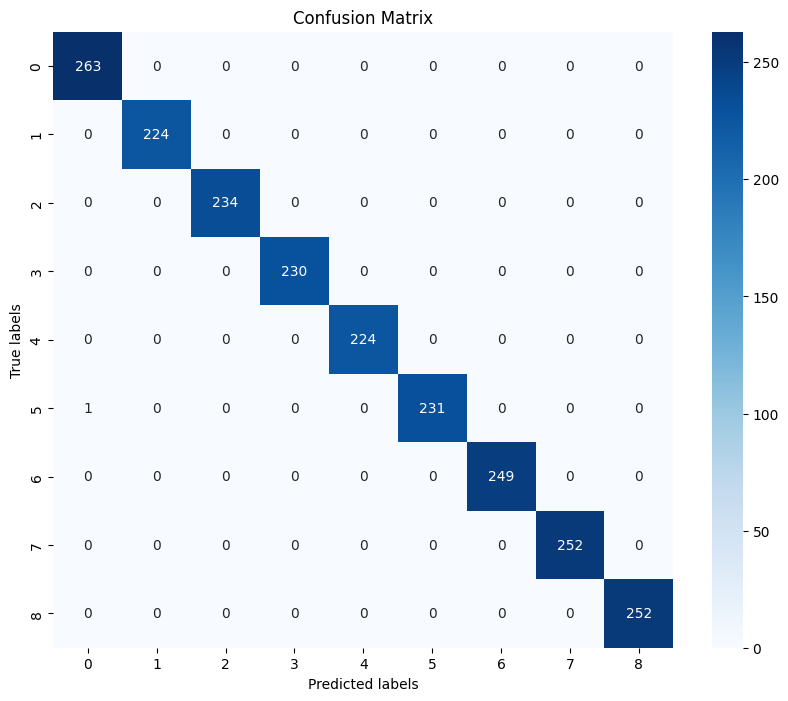

In [ ]:
import seaborn as sns

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(9), yticklabels=range(9))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

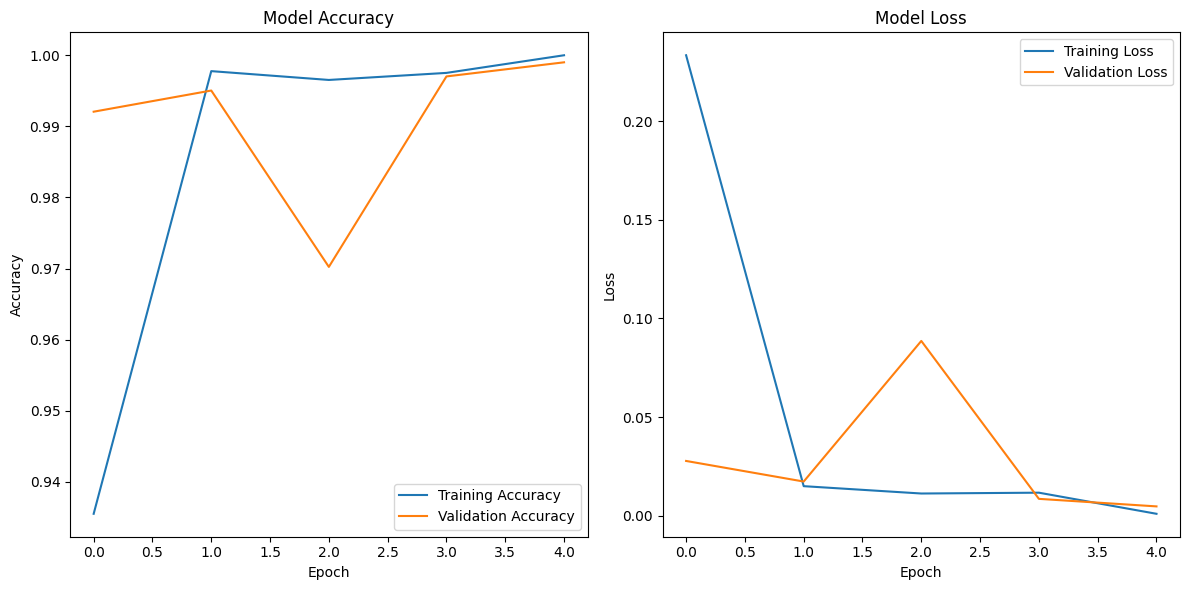

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

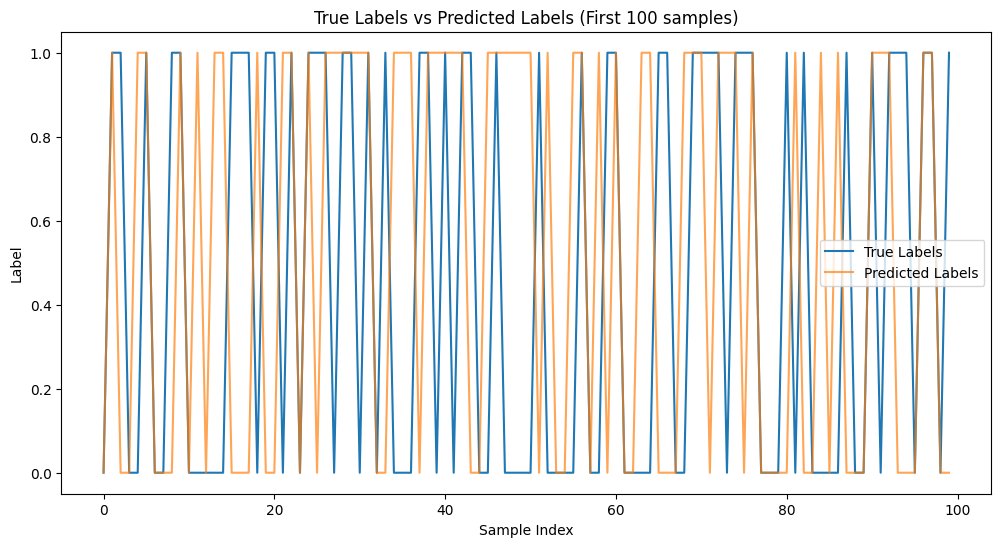

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration (replace these with your actual data)
y_true = np.random.randint(0, 2, 100)  # Example: 100 true labels
y_pred = np.random.randint(0, 2, 100)  # Example: 100 predicted labels

# Ensure y_true and y_pred are numpy arrays or lists and have the same length
assert len(y_true) == len(y_pred), "y_true and y_pred must have the same length"

# Plotting the true vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(y_true[:100], label="True Labels")
plt.plot(y_pred[:100], label="Predicted Labels", alpha=0.7)
plt.legend()
plt.title('True Labels vs Predicted Labels (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.show()

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.5 MB/s eta 0:00:00


1/1 [==============================] - 2s 2s/step


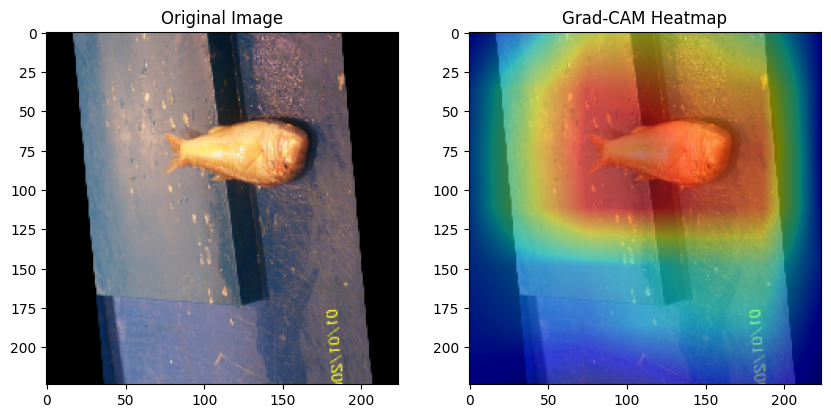

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import tensorflow as tf

# Load and preprocess a sample image from the test set
sample_image_path = test_df['Filepath'].iloc[6]
img = image.load_img(sample_image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

# Create a GradCAM object
gradcam = Gradcam(model,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

# Generate heatmap
score = CategoricalScore([np.argmax(model.predict(img))])
heatmap = gradcam(score, img)[0]

# Display the original image and the heatmap
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.array_to_img(img[0]))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image.array_to_img(img[0]))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('Grad-CAM Heatmap')

plt.show()

Found 4032 validated image filenames belonging to 9 classes.
Found 1008 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.
68/68 [==============================] - 20s 293ms/step


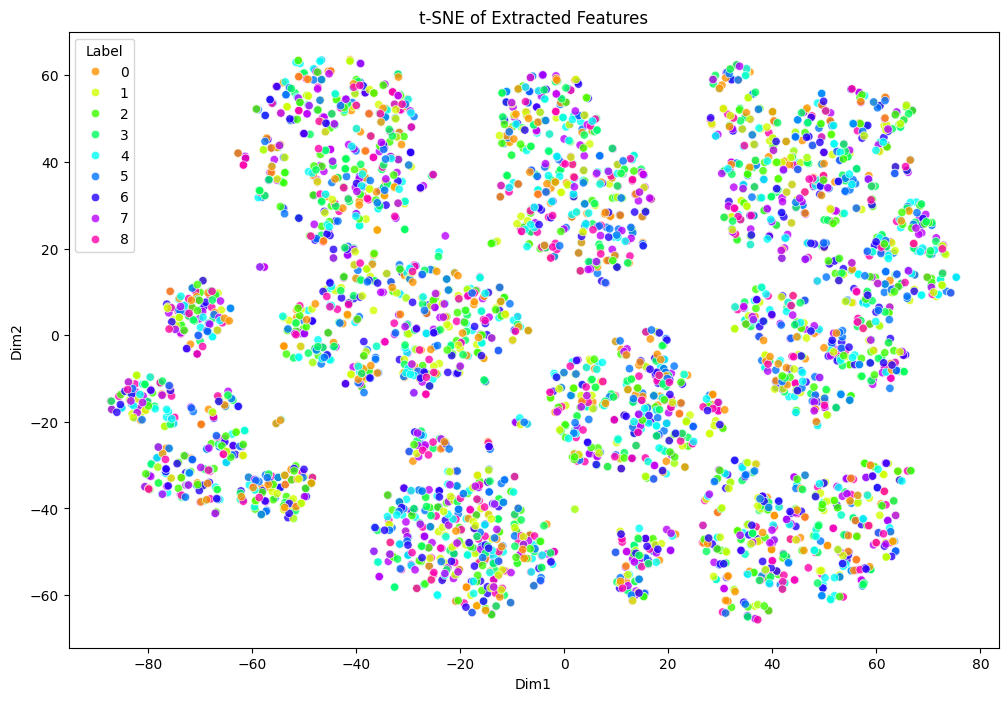

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Define the directory containing the dataset
image_dir = Path('/content/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Verify file paths and remove missing files
verified_filepaths = []
verified_labels = []
for path, label in zip(filepaths, labels):
    if os.path.exists(path):
        verified_filepaths.append(path)
        verified_labels.append(label)
    else:
        print(f"File not found: {path}")

# Convert filepaths and labels to pandas Series
filepaths = pd.Series(verified_filepaths, name='Filepath').astype(str)
labels = pd.Series(verified_labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

# Sample 800 images from each class
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(800, random_state=1))

# Combine sampled images into a single DataFrame and shuffle
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Define the data generators
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Load pretrained model for feature extraction
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# Extract features from images using the pre-trained model
def extract_features(generator):
    features = pretrained_model.predict(generator)
    labels = generator.classes
    return features, labels

# Extract features for training, validation, and test sets
train_features, train_labels = extract_features(train_images)
val_features, val_labels = extract_features(val_images)
test_features, test_labels = extract_features(test_images)

# Perform t-SNE on the extracted features
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(train_features_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Label'] = np.argmax(to_categorical(train_labels, num_classes=9), axis=1)

# Plot the t-SNE features as a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.scatterplot(
    x='Dim1', y='Dim2',
    hue='Label',
    palette=sns.color_palette('hsv', 9),
    data=tsne_df,
    legend='full',
    alpha=0.8
)
plt.title('t-SNE of Extracted Features')
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(train_features, rowvar=False)

# Convert the correlation matrix to a DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix)


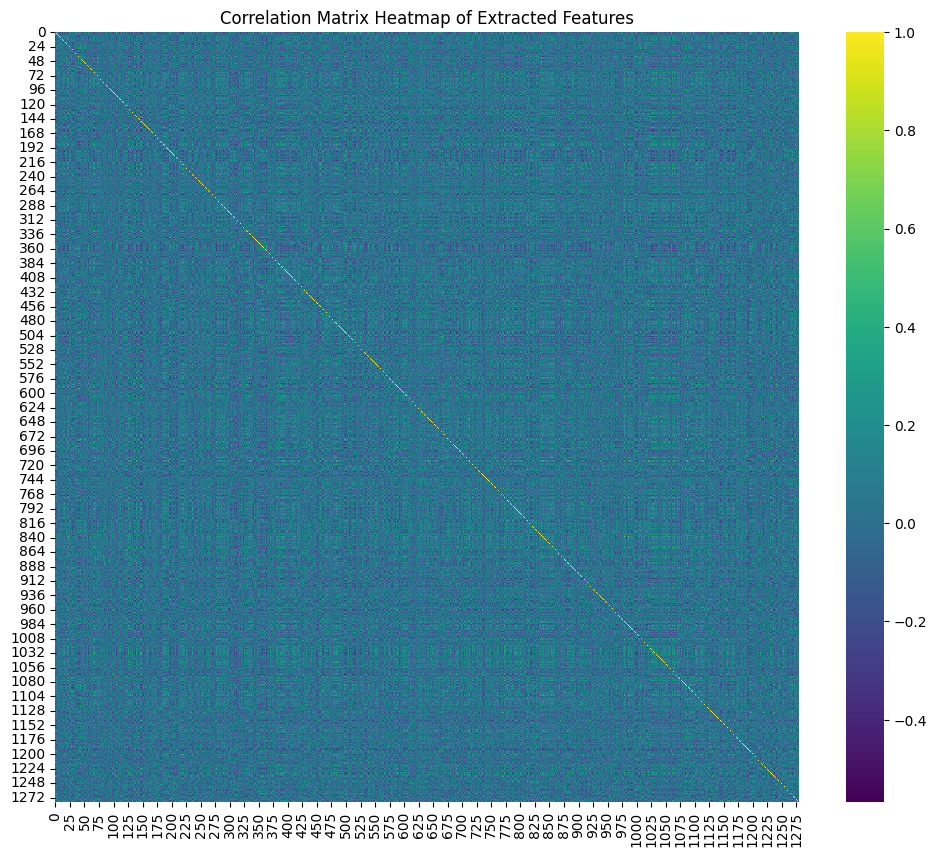

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_df, cmap='viridis')
plt.title('Correlation Matrix Heatmap of Extracted Features')
plt.show()


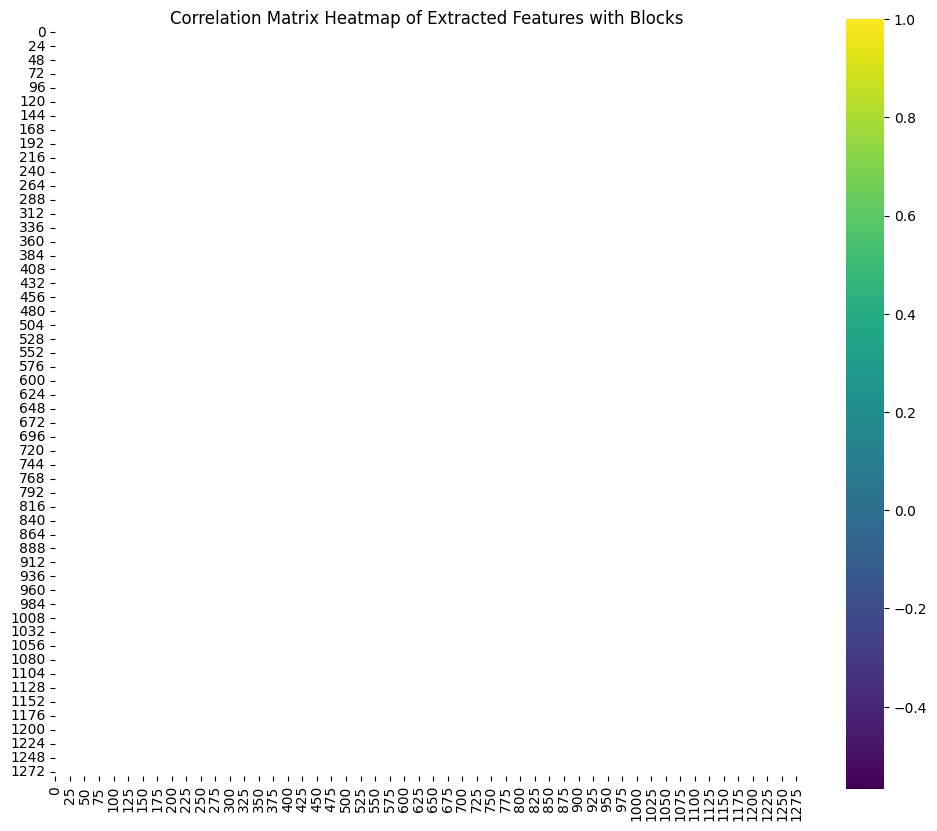

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap with larger blocks
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_df, cmap='viridis', square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap of Extracted Features with Blocks')
plt.show()


In [ ]:
# Extract features and labels for training set
train_features, train_labels = extract_features(train_images)

# Convert labels to their respective class names
class_names = list(train_images.class_indices.keys())
class_labels = [class_names[label] for label in train_labels]

# Create a DataFrame with features and their respective class labels
features_df = pd.DataFrame(train_features)
features_df['Label'] = class_labels

# Compute the mean feature vector for each class
mean_features_df = features_df.groupby('Label').mean()


126/126 [==============================] - 37s 296ms/step


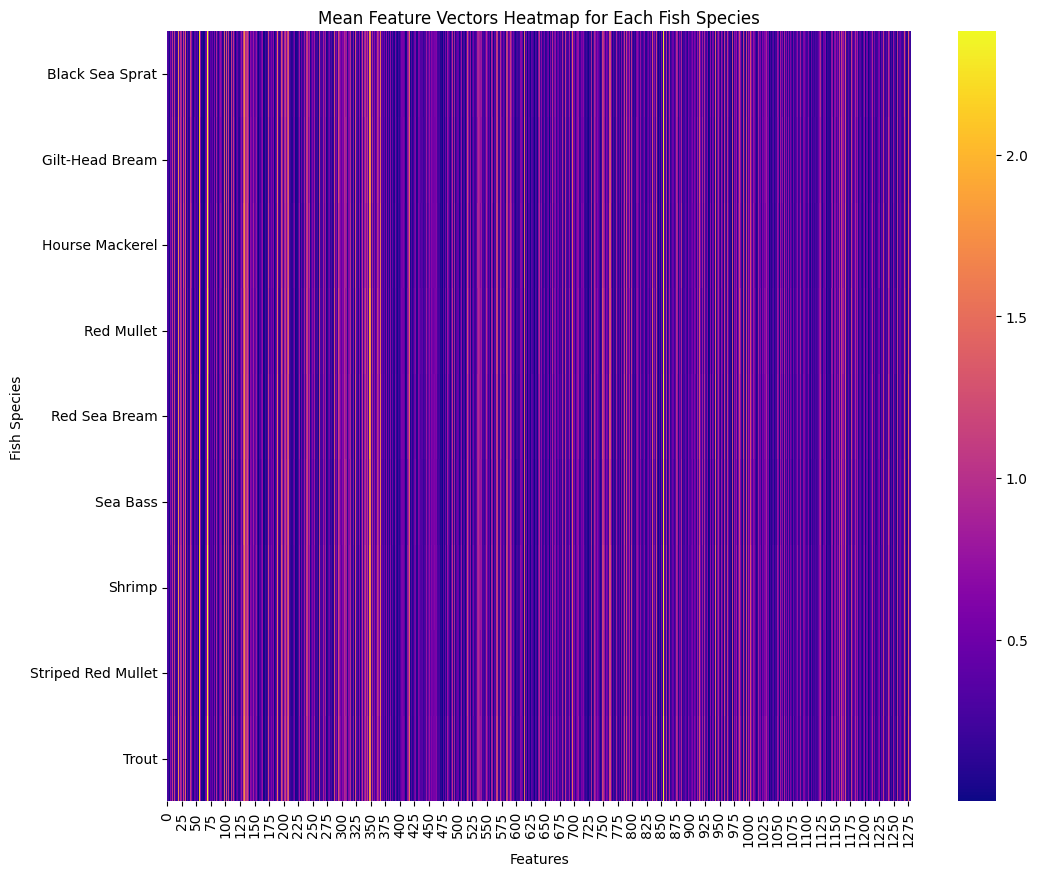

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the mean feature vectors as a heatmap
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(mean_features_df, cmap='plasma')
plt.title('Mean Feature Vectors Heatmap for Each Fish Species')
plt.xlabel('Features')
plt.ylabel('Fish Species')
plt.show()


In [ ]:
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color
import numpy as np

# Define function to compute GLCM features
def compute_glcm_features(image):
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)
    # Compute the GLCM
    glcm = greycomatrix(np.uint8(gray_image * 255), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # Compute GLCM properties
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    return contrast, dissimilarity, homogeneity, energy, correlation

# Example usage:
image_path = '/content/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00006.png'
image = io.imread(image_path)
contrast, dissimilarity, homogeneity, energy, correlation = compute_glcm_features(image)


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [ ]:
# Iterate over the images and compute GLCM features for each
glcm_features = []
for image_path in image_df['Filepath']:
    image = io.imread(image_path)
    features = compute_glcm_features(image)
    glcm_features.append(features)

# Add GLCM features to the DataFrame
glcm_df = pd.DataFrame(glcm_features, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
glcm_df['Label'] = image_df['Label']


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0

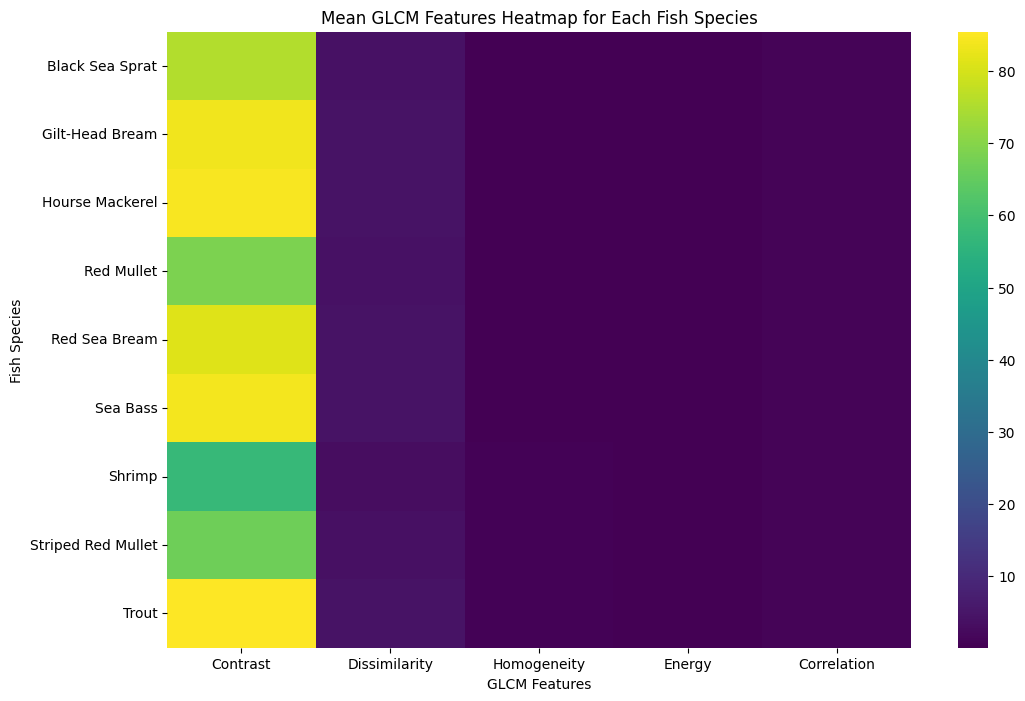

In [ ]:
# Compute mean GLCM features for each class
mean_glcm_df = glcm_df.groupby('Label').mean()

# Plot the mean GLCM features as a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(mean_glcm_df, cmap='viridis')
plt.title('Mean GLCM Features Heatmap for Each Fish Species')
plt.xlabel('GLCM Features')
plt.ylabel('Fish Species')
plt.show()


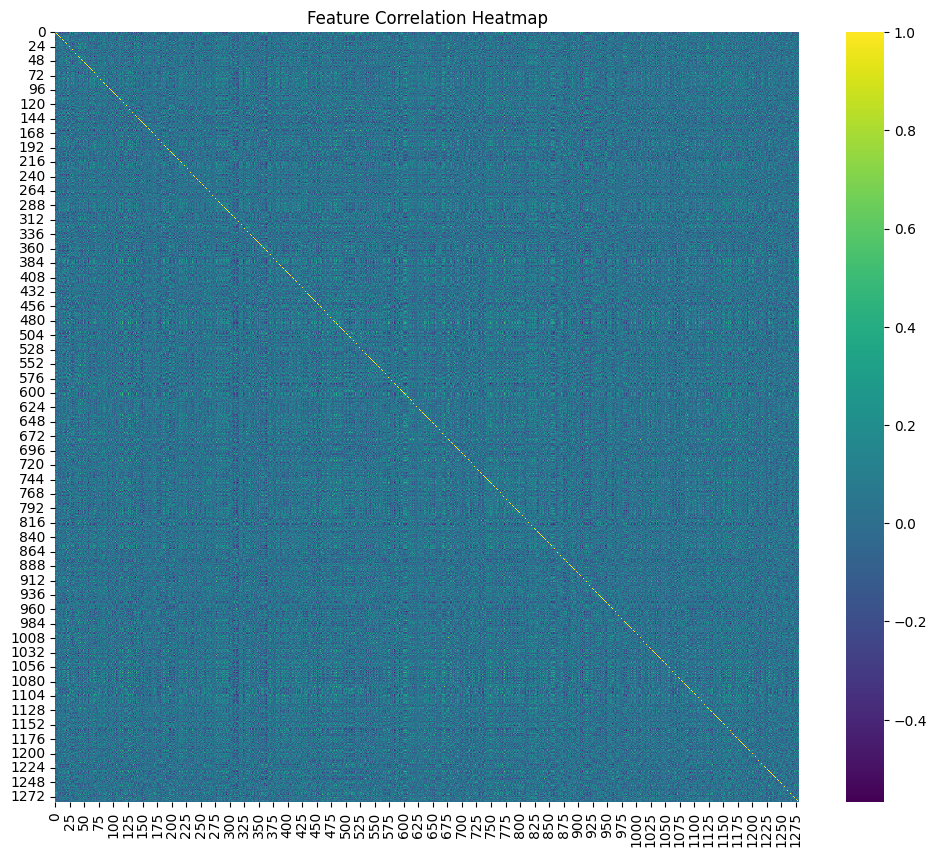

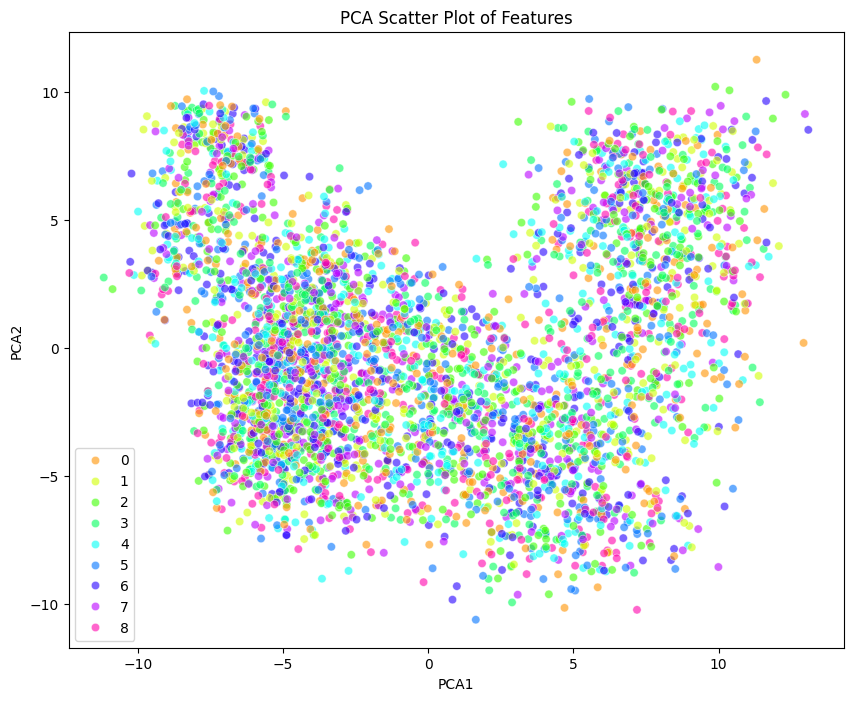

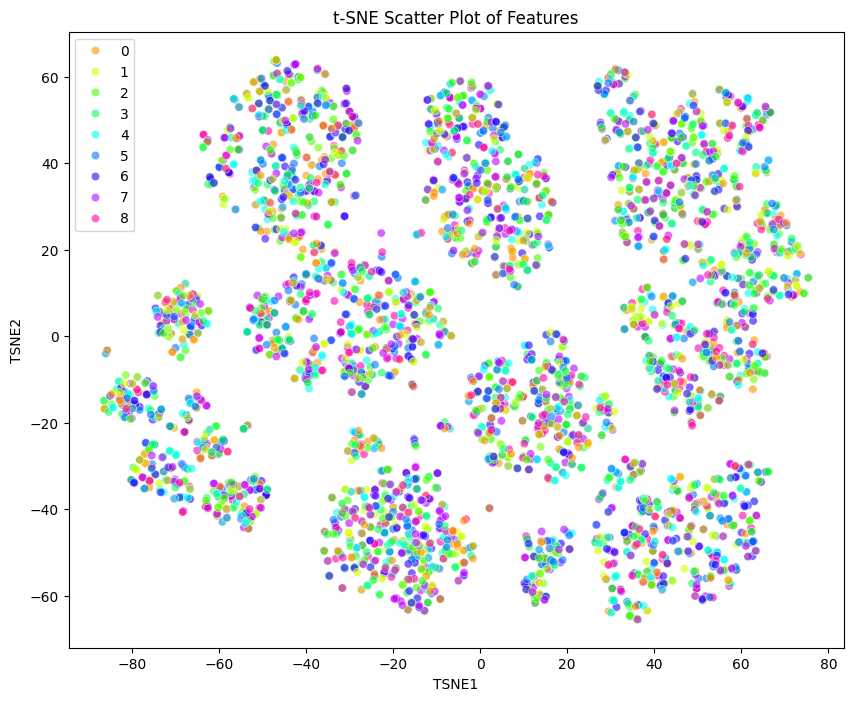

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Create a DataFrame for features and labels
train_features_df = pd.DataFrame(train_features)
train_labels_df = pd.DataFrame(train_labels, columns=['Label'])

# Combine features and labels into a single DataFrame
features_df = pd.concat([train_features_df, train_labels_df], axis=1)

# Calculate the correlation matrix
corr_matrix = features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Feature Correlation Heatmap')
plt.show()

# Dimensionality Reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_features)
features_df['PCA1'] = pca_result[:, 0]
features_df['PCA2'] = pca_result[:, 1]

# Scatter plot using PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue=train_labels,
    palette=sns.color_palette("hsv", 9),
    data=features_df,
    legend="full",
    alpha=0.6
)
plt.title('PCA Scatter Plot of Features')
plt.show()

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_features)
features_df['TSNE1'] = tsne_result[:, 0]
features_df['TSNE2'] = tsne_result[:, 1]

# Scatter plot using t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    hue=train_labels,
    palette=sns.color_palette("hsv", 9),
    data=features_df,
    legend="full",
    alpha=0.6
)
plt.title('t-SNE Scatter Plot of Features')
plt.show()

1/1 [==============================] - 1s 1s/step
Feature map shape for layer Conv_1_bn: (1, 7, 7, 1280)


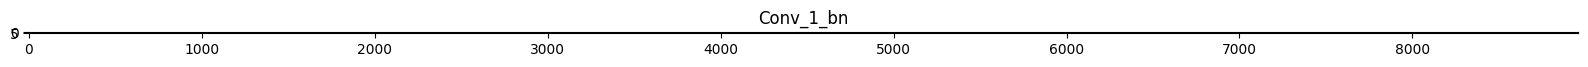

Feature map shape for layer out_relu: (1, 7, 7, 1280)


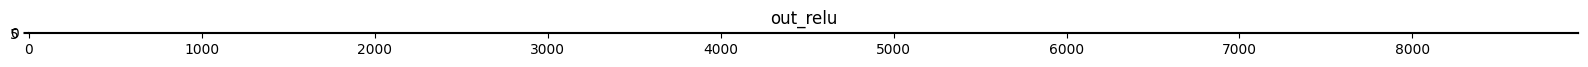

Feature map shape for layer global_average_pooling2d_1: (1, 1280)
Skipping layer global_average_pooling2d_1 with shape (1, 1280) as it does not have 4 dimensions.


In [ ]:
# Choose an image to visualize features
img_path = '/content/NA_Fish_Dataset/Horse Mackerel/00007.png'  # Replace with the path to your image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Create a model that outputs feature maps from specific layers
layer_names = [layer.name for layer in pretrained_model.layers]
selected_layers = [pretrained_model.get_layer(name).output for name in layer_names[-3:]]  # Last 3 layers as an example
feature_model = tf.keras.Model(inputs=pretrained_model.input, outputs=selected_layers)

# Get feature maps
feature_maps = feature_model.predict(img_array)

# Visualize feature maps
for layer_name, feature_map in zip(layer_names[-3:], feature_maps):
    print(f"Feature map shape for layer {layer_name}: {feature_map.shape}")

    # Check if the feature map has the expected dimensions
    if len(feature_map.shape) == 4:
        num_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * num_features))

        for i in range(num_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std() + 1e-5
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

        scale = 20. / num_features
        plt.figure(figsize=(scale * num_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')
        plt.show()
    else:
        print(f"Skipping layer {layer_name} with shape {feature_map.shape} as it does not have 4 dimensions.")


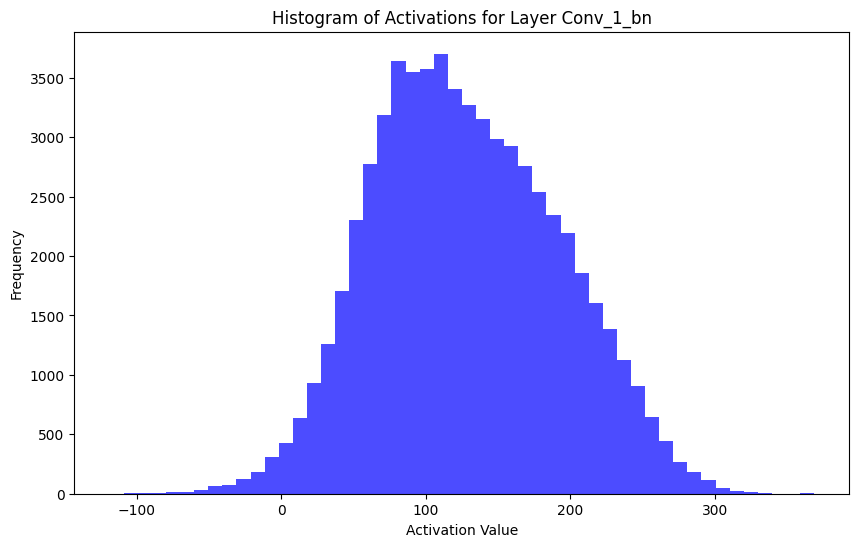

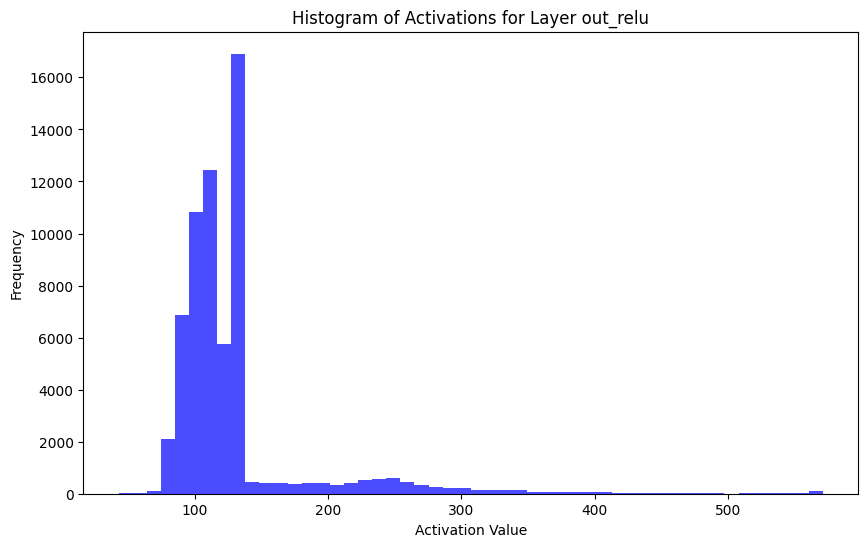

In [ ]:
# Plot histograms of feature activations for a particular layer
for layer_name, feature_map in zip(layer_names[-3:], feature_maps):
    if len(feature_map.shape) == 4:
        num_features = feature_map.shape[-1]

        # Flatten the feature map for histogram
        feature_map_flat = feature_map.flatten()

        plt.figure(figsize=(10, 6))
        plt.hist(feature_map_flat, bins=50, color='blue', alpha=0.7)
        plt.title(f'Histogram of Activations for Layer {layer_name}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.show()

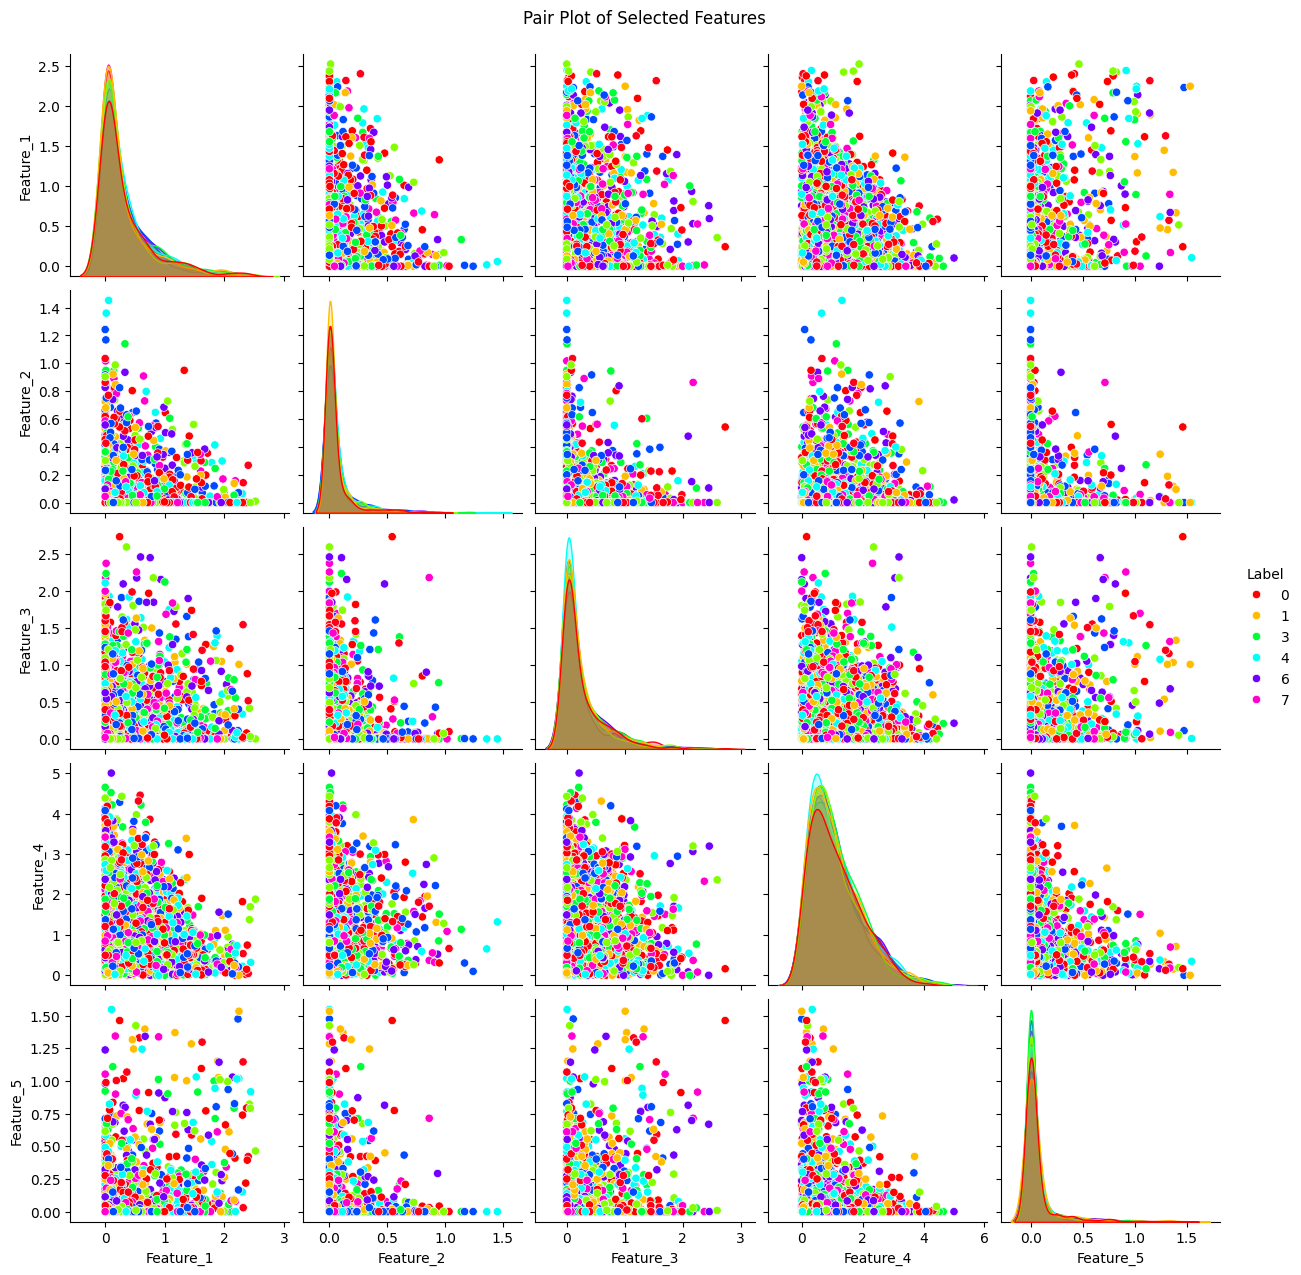

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

# Select a subset of features for pair plot (e.g., first 5 features)
subset_features = train_features[:, :5]
subset_features_df = pd.DataFrame(subset_features, columns=[f'Feature_{i}' for i in range(1, 6)])
subset_features_df['Label'] = train_labels

# Plot pair plot
sns.pairplot(subset_features_df, hue='Label', palette='hsv')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()

In [ ]:
import math
# Determine the number of features and calculate the number of rows and columns for subplots
num_features = len(feature_label_df.columns) - 1  # Exclude the last column (label)
num_rows = math.ceil(num_features / 3)
num_cols = min(num_features, 3)

In [ ]:
# Plot histograms for each feature, grouped by class
plt.figure(figsize=(num_cols * 5, num_rows * 4))
for idx, feature in enumerate(feature_label_df.columns[:-1]):  # Exclude the last column (label)
    plt.subplot(num_rows, num_cols, idx + 1)
    sns.histplot(data=feature_label_df, x=feature, hue='Label', kde=True, bins=20, palette='hsv')
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# Plot box plots for each feature, grouped by class
plt.figure(figsize=(num_cols * 5, num_rows * 4))
for idx, feature in enumerate(feature_label_df.columns[:-1]):  # Exclude the last column (label)
    plt.subplot(num_rows, num_cols, idx + 1)
    sns.boxplot(data=feature_label_df, x='Label', y=feature, palette='hsv')
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

<ipython-input-52-dec96698302a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_label_df, x='Label', y=feature, palette='hsv')
<ipython-input-52-dec96698302a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_label_df, x='Label', y=feature, palette='hsv')
<ipython-input-52-dec96698302a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_label_df, x='Label', y=feature, palette='hsv')
<ipython-input-52-dec96698302a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remo

In [ ]:
plt.figure(figsize=(12, 8))
for feature in feature_label_df.columns[:-1]:  # Exclude the last column (label)
    plt.subplot(3, 3, feature_label_df.columns.get_loc(feature) + 1)
    sns.histplot(data=feature_label_df, x=feature, y='Label', palette='hsv', cbar=True)
    plt.title(f'Joint Plot of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
# List all features
features_list = feature_label_df.columns[:-1].tolist()  # Exclude the last column (label)
print("List of all features:")
print(features_list)

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Overall Accuracy:", accuracy)

# Calculate accuracy per class
class_accuracy = []
for class_idx in range(num_classes):
    class_true_labels = true_labels[true_labels == class_idx]
    class_predicted_labels = predicted_labels[true_labels == class_idx]
    class_accuracy.append(accuracy_score(class_true_labels, class_predicted_labels))

# Visualize accuracy per class
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), class_accuracy, color='skyblue')
plt.xticks(range(num_classes), class_names, rotation=45)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.ylim(0, 1)  # Set y-axis limit to ensure consistency
plt.show()